In [78]:
import os
import cv2
import random

from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt

random.seed(42)
torch.manual_seed(42)

In [79]:
SMDG = './SMDG-19'
SMDG_NORM = './SMD19-NORMALIZED'

In [80]:
images_metadata = {}

for split in os.listdir(SMDG):
    for label in os.listdir(f'{SMDG}/{split}'):
        for img in os.listdir(f'{SMDG}/{split}/{label}'):
            img_path = f'{SMDG}/{split}/{label}/{img}'
            cv2_img = cv2.imread(img_path)
            pil_img = Image.open(img_path)

            img_shape = cv2_img.shape
            mean, std = cv2.meanStdDev(cv2_img)

            c1mean, c2mean, c3mean = mean.flatten()
            c1std, c2std, c3std = std.flatten()

            images_metadata[img_path] = {
                'path': img_path,
                'split': split,
                'label': label,
                'x': img_shape[0],
                'y': img_shape[1],
                'c': img_shape[2],
                'nbytes': cv2_img.nbytes, 
                'c1mean': c1mean, 'c2mean': c2mean, 'c3mean': c3mean,
                'c1std': c1std, 'c2std': c2std, 'c3std': c3std,
                'metadata': str(pil_img.info)
            }

all_images_metadata = pd.DataFrame(list(images_metadata.values()))

In [81]:
all_images_metadata['metadata'].unique()

array(['{}'], dtype=object)

In [82]:
all_images_metadata[['x', 'y', 'c']].describe()

,x,y,c
count,17242.0,17242.0,17242.0
mean,512.0,512.0,3.0
std,0.0,0.0,0.0
min,512.0,512.0,3.0
25%,512.0,512.0,3.0
50%,512.0,512.0,3.0
75%,512.0,512.0,3.0
max,512.0,512.0,3.0


In [83]:
all_images_metadata[['c1mean', 'c2mean', 'c3mean']].describe()

,c1mean,c2mean,c3mean
count,17242.000000,17242.000000,17242.000000
mean,34.412561,61.348457,103.518042
std,21.468394,23.669952,33.496327
min,0.713036,2.299706,6.746002
25%,17.549454,43.417679,78.695892
50%,30.601891,61.515182,105.285843
75%,48.039089,76.071762,127.169964
max,139.788353,165.734898,199.864334


In [84]:
all_images_metadata[['c1std', 'c2std', 'c3std']].describe()

,c1std,c2std,c3std
count,17242.000000,17242.000000,17242.000000
mean,23.652445,40.189526,65.026369
std,12.907551,13.420236,18.571227
min,0.914415,5.026230,7.500251
25%,13.787494,29.897358,51.590151
50%,21.595093,40.587321,65.089158
75%,31.780338,48.948443,77.252747
max,98.673467,104.026515,115.655771


In [85]:
# https://www.sciencedirect.com/topics/engineering/green-channel
# 'Contrast normalization is usually applied to the “green” channel [4–7], as it is less sensitive to noise'
def green_channel_and_clahe(imh_path: str) -> torch.Tensor:
    img = cv2.imread(imh_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    return torch.tensor(img)

In [86]:
import torchvision.transforms as T

def standardize_and_transform(img_tensor: torch.Tensor) -> torch.Tensor:
    img = img_tensor.clone()

    img = img.float()

    # Standardize by min max
    img = (img - img.min()) / (img.max() - img.min())

    # Transforms:
    # 1. With 50% probability, flip horizontally
    if torch.rand(1) > 0.5:
        img = torch.flip(img, dims=[1])

    # 2. With 50% probability, flip vertically
    if torch.rand(1) > 0.5:
        img = torch.flip(img, dims=[0])

    # 3. With 50% probability, rotate 90 degrees
    if torch.rand(1) > 0.5:
        img = torch.rot90(img, k=1, dims=[0, 1])

    # 4. With 50% probability, rotate 180 degrees
    if torch.rand(1) > 0.5:
        img = torch.rot90(img, k=2, dims=[0, 1])

    # 5. With 50% probability, add Gaussian noise
    if torch.rand(1) > 0.5:
        img = img.unsqueeze(0)
        img = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))(img)
        img = img.squeeze(0)

    return img

In [87]:
# Based on channels mean and std, we can see that the images are not normalized

# Normalize images using min max normalization
for image_metadata in images_metadata.values():
    img_path = image_metadata['path']
    gr: torch.Tensor = green_channel_and_clahe(img_path)
    gr = standardize_and_transform(gr)
    new_img_path = img_path.replace(SMDG, SMDG_NORM)
    new_img_path = new_img_path.replace('.png', '.pt')
    os.makedirs(os.path.dirname(new_img_path), exist_ok=True)
    torch.save(gr, new_img_path)

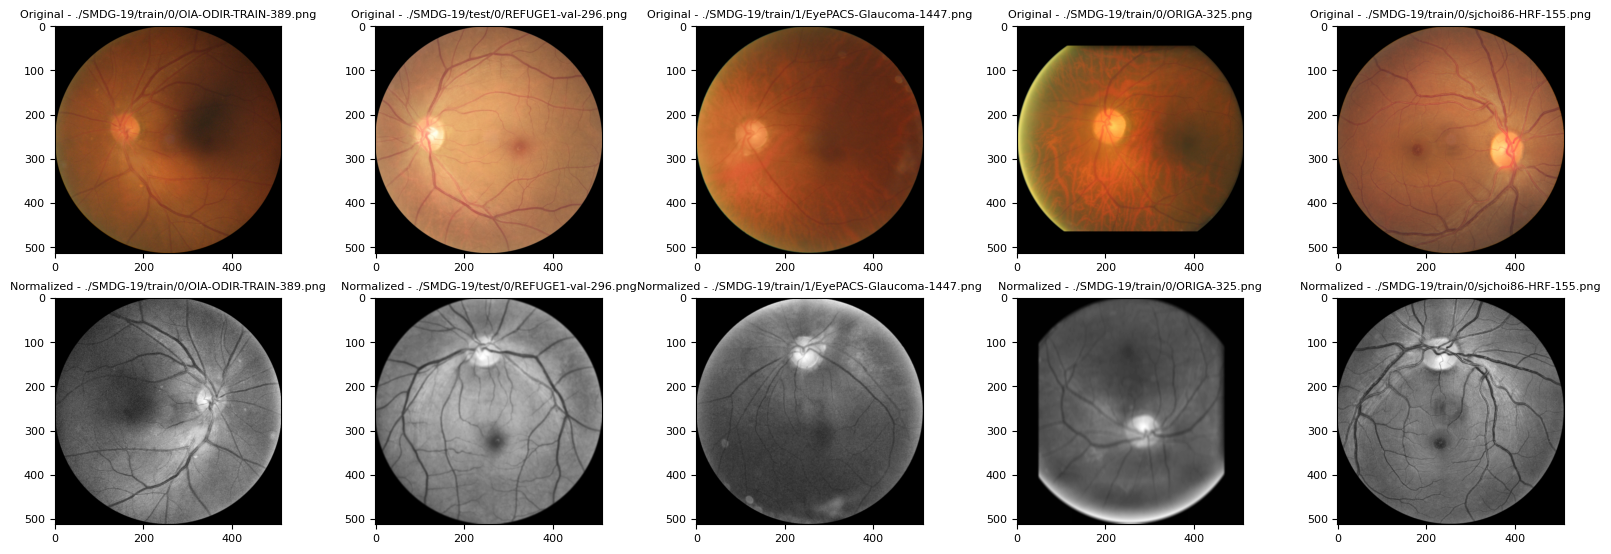

In [88]:
image_paths = list(images_metadata.keys())
image_paths = random.sample(image_paths, 5)

fig = plt.figure(figsize=(20, 10))

# Original
for i, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(3, 5, i + 1)
    ax.set_title(f'Original - {image_path}') 
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)

    ax.imshow(img)

# Normalized
for i, image_path in enumerate(image_paths):
    img = torch.load(image_path.replace(SMDG, SMDG_NORM).replace('.png', '.pt'))
    img = img.numpy()
    ax = fig.add_subplot(3, 5, i + 6)
    ax.set_title(f'Normalized - {image_path}') 

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)

    ax.imshow(img, cmap='gray')
